In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import random
import matplotlib.animation as animation

In [3]:
def energy_calc(lattice):
    ''' Calculate lattice energy, first copies of the lattice shifted once along the columns and once along the rows are made.
        Multiplication of these copies with the lattice will give all nearest neighbour interactions(without double counting).
        Input: lattice array with a configuration of spins (each element of the array being 1 or -1)
        Output: total energy of the lattice '''
    a = lattice[:,1:]*lattice[:,:N-1]
    b = lattice[:N-1,:]*lattice[1:,:]
    # To ensure periodic boundary conditions the last column is multiplied with the first column of the lattice array. 
    # Same is done with the rows.
    c = lattice[0]*lattice[N-1]
    d = lattice[:,0]*lattice[:,N-1]
    # Energy:
    E = -1*(np.sum(a)+np.sum(b)+np.sum(c)+np.sum(d))
    
    return(E)

In [4]:
def energy_nn(lattice,x,y):
    ''' Calculate nearest neighbour interaction energy of 1 spin. 
        Input: lattice array with a configuration of spins (each element of the array being 1 or -1); lattice position of a
        selected spin. 
        Output: nearest neighbour interaction energy of the selected spin '''
    s = lattice[x,y]
    nn = lattice[(x+1)%N,y] + lattice[(x-1)%N,y] + lattice[x,(y+1)%N] + lattice[x,(y-1)%N]
    E = -1*nn*s
    
    return(E)

In [5]:
def metropolis(lattice,E,M):
    ''' Implement metropolis algorithm. 
    Input: lattice array with a configuration of spins; total energy E of the lattice; total magnetisation M of the lattice
    Output: updated lattice, energy E and magnetisation M according to the metropolis algorithm '''
    # Select random spin (propose trial lattice with probability 1/L^2):
    x = random.randrange(0,N)
    y = random.randrange(0,N)
    trial_lattice = np.copy(lattice)
    trial_lattice[x,y] *= -1
    # Calculate energy difference between the old and trial configurations:
    dE = energy_nn(trial_lattice,x,y) - energy_nn(lattice,x,y)
    # Implement second stage of the metropolis algorithm:
    if dE <= 0:
        E = E + dE
        M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
        lattice[x,y] = trial_lattice[x,y]
    else:
        r = random.uniform(0,1)
        if dE == 4:
            p = A[0]
        else:
            p = A[1]
        if r < p:
            E = E + dE
            M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
            lattice[x,y] = trial_lattice[x,y]
            
    return(lattice,E,M)

In [6]:
def make_anim(configs,N_frames):
    ''' Create animation of the evolution of the lattice.
        Input: 3D array configs, which contains the configuration of the lattice at each timestep; number of frames needs to 
        match the number of timesteps.
        Output: animation. '''
        
    fig = plt.figure()
    im = plt.imshow(configs[0], vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))
    
    def init():
    
        return(configs[0])
    
    def animate(i):
        im.set_data(configs[i])
    
        return(im)
    
    anim = animation.FuncAnimation(fig, animate,init_func=init, frames=N_frames, interval=750)
    
    return(anim)

In [7]:
def sample(data):
    ''' Create data per sample (interval of MCS). Quantities such as energy or magnetisation are averaged over a sample.
    Input: data points such as energy or magnetisation as a function of MCS.
    Output: averages over the datapoints per sample; standard deviation of the datapoints per sample. '''
    values=[]
    std = []
    # normalize data (per spin/lattice site):
    data = np.array(data)/(N**2)
    for i in range(N_samples):
        a = np.mean(data[i*t_prod:t_prod*(i+1)])
        b = np.std(data[i*t_prod:t_prod*(i+1)])
        values.append(a)
        std.append(b)
    values = np.array(values)
    std = np.array(std)
    
    return({'values': values, 'std': std})

In [8]:
def autocor(x):
    x = np.array(x)
    result = np.correlate(x,x,mode='full')
    result = result/max(result)
    return result[result.size/2:]


4 6


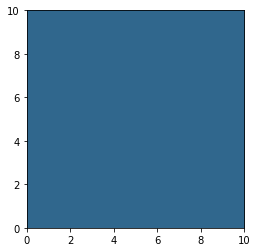

-200.0 100.0
[]
-136.0 -82.0
-136.0 -82.0


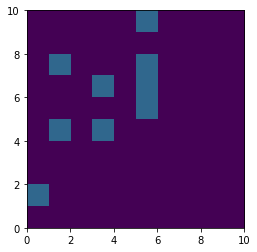

"lattice, E, M = Wolff(lattice, E, M)\nplt.figure()\nplt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))\nplt.show()\nlattice, E, M = Wolff(lattice, E, M)\nplt.figure()\nplt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))\nplt.show()"

In [9]:
N=10
x = random.randrange(0,N)
y = random.randrange(0,N)
print(x,y)
cluster = []


tau=2/np.log(2)

def backtrack(x,y):
    """Checks if a given spin has been added to the cluster"""
    global cluster
    for i in range(len(cluster)):
        if [x,y] == cluster[i]:
            return False
    return True

def grow_cluster(lattice,x,y,ClusterSpin,E,M):
    """Starting from a randomly chosen spin, creates a cluster with the Wolff Algorithm."""
    old_E = energy_nn(lattice,x,y)
    lattice[x,y] *=-1
    dE = energy_nn(lattice,x,y) - old_E
    E = E + dE
    M = M - lattice[x,y]*-1 +lattice[x,y]
    cluster.append([x,y])
    if backtrack((x+1)%N,y):
        E, M = try_add(lattice,(x+1)%N,y,ClusterSpin,E,M)
    if backtrack((x-1)%N,y):
        E, M = try_add(lattice,(x-1)%N,y,ClusterSpin,E,M)
    if backtrack(x,(y+1)%N):
        E, M = try_add(lattice,x,(y+1)%N,ClusterSpin,E,M)
    if backtrack(x,(y-1)%N):
        E, M = try_add(lattice,x,(y-1)%N,ClusterSpin,E,M)
    return(lattice,E,M)
def try_add(lattice,x,y,ClusterSpin,E,M):
    """Checks of neighbor belongs to cluster, if so then add neighbor to cluster with a certain probability"""
    s_help = lattice[x,y]
    if ((s_help<0) != (ClusterSpin<0)):
        r = random.uniform(0,1)
        if r < (1-np.exp(-2/tau)):
            lattice, E, M = grow_cluster(lattice,x,y,ClusterSpin,E,M)
    return(E,M)

def Wolff(lattice,E,M):
    x = random.randrange(0,N)
    y = random.randrange(0,N)
    cluster = []
    clusterspin = lattice[x,y]*-1
    lattice, E, M = grow_cluster(lattice,x,y,clusterspin, E, M)
    print(cluster)
    return(lattice,E,M)
    

lattice = np.random.choice([-1,1],(N,N))
lattice = np.ones((N,N))
E = energy_calc(lattice)
M = np.sum(lattice)
plt.figure()
plt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))
plt.show()
x,y=0,0
clusterspin = lattice[x,y]*-1
print(E, M)

#E, M = grow_cluster(x,y,clusterspin, E, M)

lattice, E, M = Wolff(lattice, E, M)
print(E,M)
print(energy_calc(lattice), np.sum(lattice))
plt.figure()
plt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))
plt.show()

"""lattice, E, M = Wolff(lattice, E, M)
plt.figure()
plt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))
plt.show()
lattice, E, M = Wolff(lattice, E, M)
plt.figure()
plt.imshow(lattice, vmin=0.5, vmax=2, interpolation='none', extent=(0,N,0,N))
plt.show()"""

# Simulation 

In [ ]:
# vary temperature during simulation?
vary = False

# set parameters and initial values
N = 32# lattice number
tau = 0.001# reduced temperature (kT/J)
N_samples = 30
t_eq = 10
t_prod = 5

# no need for equilibrium time when temperature is kept constant:
if vary == False:
    t_eq = 0
    
t_sample = t_eq + t_prod # sample time in units of MCS, from  data is extracted

#lattice = np.random.choice([1,-1],size=(N,N))
lattice = np.ones((N,N))
E = energy_calc(lattice)
A = np.array([np.exp(-4/tau),np.exp(-8/tau)]) # store possible values of the acceptance probability (can only be two values)
M = np.sum(lattice) # magnetisation
T = np.linspace(1,7,N_samples) # set temperatures

configs = np.zeros([N_samples*t_sample,N,N]) # array to keep track of the lattice with each time step
energy = [] # empty list to store the energy E with each time step
magnetisation = [] # empty list to store the magnetisation M with each time step

lattice_wolff = np.copy(lattice)
E_wolff = E
M_wolff = M
configs_wolff=np.zeros([N_samples*t_sample,N,N])
energy_wolff = []
magnetisation_wolff = []

for i in range(N_samples):
    if vary == True:
        tau = T[i]
        A = np.array([np.exp(-4/tau),np.exp(-8/tau)])
    for j in range(t_sample):
        if j >= (t_eq):
            magnetisation.append(M/N**2)
            energy.append(E)
            energy_wolff.append(E_wolff)
            magnetisation_wolff.append(M_wolff/N**2)
        configs[j+i*t_sample] = lattice
        configs_wolff[j+i*t_sample] = lattice_wolff
        # perform metropolis algorithm for on MCS:
        for k in range(N**2):
            lattice, E, M = metropolis(lattice,E,M)
        #lattice_wolff, E_wolff, M_wolff = Wolff(lattice_wolff,E_wolff,M_wolff)
        x = random.randrange(0,N)
        y = random.randrange(0,N)
        cluster = []
        clusterspin = lattice_wolff[x,y]*-1
        lattice_wolff, E_wolff, M_wolff = grow_cluster(lattice_wolff,x,y,clusterspin,E_wolff,M_wolff)


KeyboardInterrupt: 

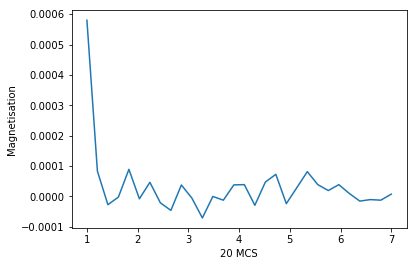

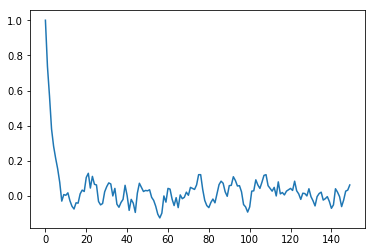

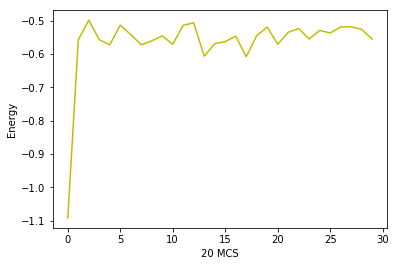

In [241]:
# plot magnetisation and energy against MCS
m = sample(magnetisation)['values']
e = sample(energy)['values']
t = np.arange(N_samples) 

plt.figure()          
plt.plot(T,m)
plt.xlabel('20 MCS')
plt.ylabel('Magnetisation')
plt.figure()
x=np.arange(len(magnetisation))
plt.plot(x,magnetisation)
plt.show()
plt.figure()
plt.plot(t,e,color='y')
plt.xlabel('20 MCS')
plt.ylabel('Energy')

plt.show()

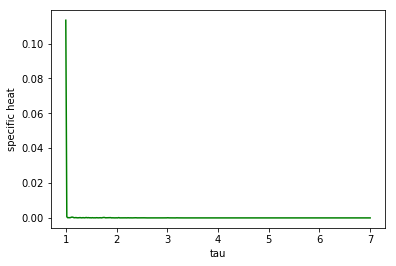

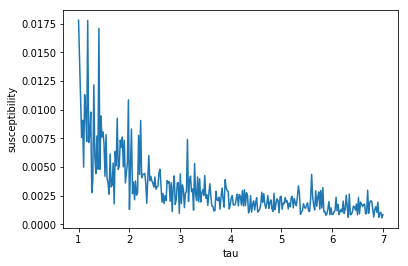

In [41]:
# plot specific heat and susceptibility 
c = sample(energy)['std']**2/T**2
plt.figure()
plt.plot(T,c,color='g')
plt.xlabel('tau')
plt.ylabel('specific heat')

X = sample(magnetisation)['std']/T
plt.figure()
plt.plot(T,X)
plt.xlabel('tau')
plt.ylabel('susceptibility')

plt.show()

In [ ]:
x=np.arange(10)
np.savetxt("test.txt",x)